# Tests on Synthetic Data
note that to run this notebook you need to download the relevant data from [Zenodo](https://zenodo.org/record/7307532/files/test_results_on_synthetic_data.tar.gz?download=1) and place it in the 'test_results' directory. 


In [1]:
import os
import sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))  # allow imports from parent dir
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from utils import get_ensemble_predictions
from plotting import set_plots_size_params
from matplotlib import patches as mpatches

In [2]:
set_plots_size_params(20)

In [3]:
grids = {}
for sumstat in ['SR', 'LR', 'L-LR']:
    for model_type in ['ensemble', 'REJ-ABC', 'big']:
        grids[f'{model_type} {sumstat}'] = pd.concat([pd.read_csv(f'5E-5_err_rate/{model_type}_{sumstat}_{replica}.csv') 
                                        for replica in ['A', 'B', 'C']])
    grids[f'ensemble {sumstat} 5E-4'] = pd.concat([pd.read_csv(f'5E-4_err_rate/ensemble_{sumstat}_{replica}.csv') 
                            for replica in ['A', 'B', 'C']])

In [4]:
grids.keys()

dict_keys(['ensemble SR', 'REJ-ABC SR', 'big SR', 'ensemble SR 5E-4', 'ensemble LR', 'REJ-ABC LR', 'big LR', 'ensemble LR 5E-4', 'ensemble L-LR', 'REJ-ABC L-LR', 'big L-LR', 'ensemble L-LR 5E-4'])

In [5]:
def drop_tensor_and_paranthesis(s):
    return s.replace('tensor(','').replace(')','')

for grid in grids.values():
    grid['theta'] = grid.theta.map(drop_tensor_and_paranthesis)

rename_dict = {'mu': r'Mutation rate (U)', 'w_ada': r'Beneficial fitness effect ($w_{b}$)', 
               'w_syn': r'Syn fitness effect ($w_{s}$)', 
               'w_non_syn': r'Non-syn fitness effect ($w_{ns}$)', 'p_ada_non_syn': r'Beneficial non-syn probability ($p_{bns}$)',
               'p_ada_syn': r'Beneficial syn probability ($p_{bs}$)', 'p0_non_syn': r'Mean initial non-syn ($M_{ns}$)', 
               'p0_syn': r'Mean initial syn ($M_{s}$)',
               'w_penalty': r'Initial log-fitness correlation ($\delta$)', 'epistasis_boost': r'Epistasis effect ($\eta$)'}

for grid in grids.values():
    grid['Inferred Parameter'] = grid.param.map(rename_dict)
    grid.loc[grid['value']==0, 'value'] = 0.00001
    grid['rel_err'] = np.log10(grid['mode'] / grid['value'])
    grid['10^'] = 10**grid['mode']
    if 'model' not in grid.columns:
        grid['model'] = 'rej'
    grid['err_ratio'] = grid.apply(lambda row: row['err'] if row['param']=='mu' else row['rel_err'], axis=1)

for grid_name in [k for k in grids.keys() if 'BIG' in k]:
    grids[grid_name] = grids[grid_name][grids[grid_name].model=='big_model.dill']

/sternadi/home/volume2/ita/miniconda/envs/sbi/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/sternadi/home/volume2/ita/miniconda/envs/sbi/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [6]:
grids_low_errs = {k:v for k,v in grids.items() if '5E-4' not in k}

In [7]:
grids_high_errs = {k:v for k,v in grids.items() if '5E-4' in k}

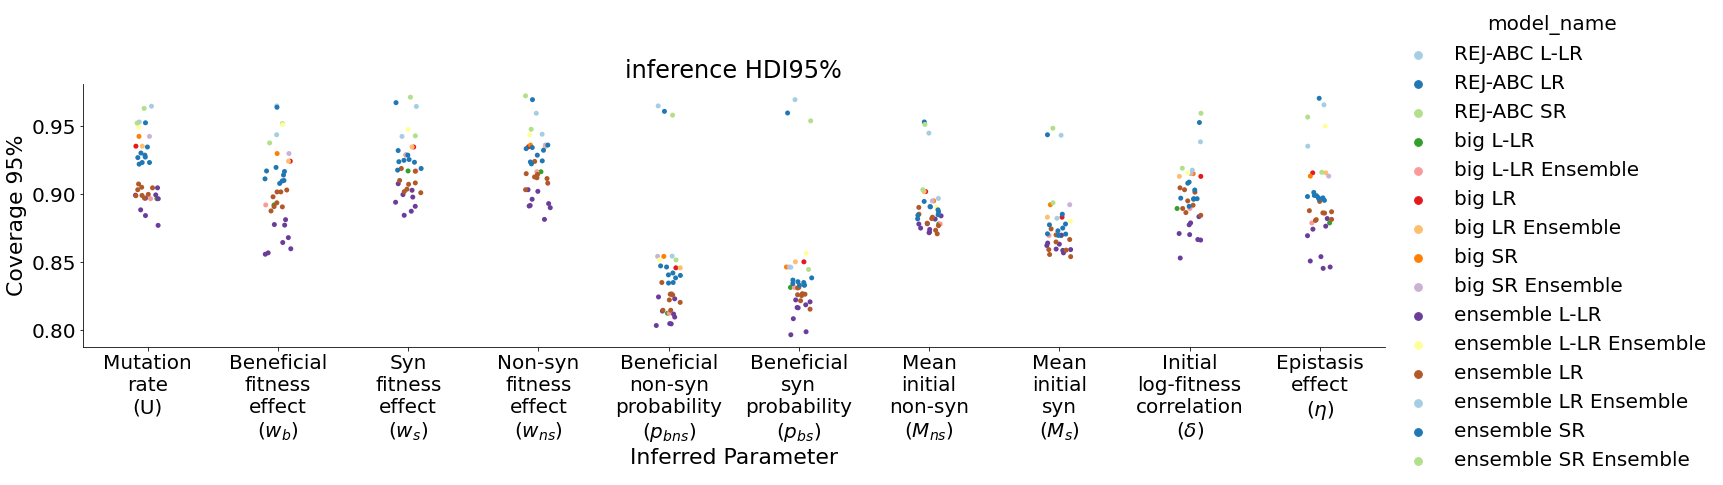

In [22]:
def fix_x_ticks():
    x_names = ['\n'.join(v.split(' ')) for v in rename_dict.values()]
    plt.xticks(range(10), x_names)

def compare_grids_coverage(grids, palette='Paired'):
    data = []
    for grid_name, grid in grids.items():
        if 'rej' in grid_name:
            continue
        datum = grid.groupby(['Inferred Parameter','model']).in_range.mean().reset_index()
        datum['model_name'] = grid_name
        datum.loc[datum.model=='ensemble','model_name'] = grid_name + ' Ensemble'
        data.append(datum)
    data = pd.concat(data)
    sns.catplot(data=data.sort_values('model_name'), x='Inferred Parameter', y='in_range',  height=5, aspect=4, 
                hue='model_name', order=rename_dict.values(), palette=palette)
    plt.ylabel('Coverage 95%')
    plt.title('inference HDI95%')
    fix_x_ticks()

compare_grids_coverage(grids_low_errs)


## Fig S2

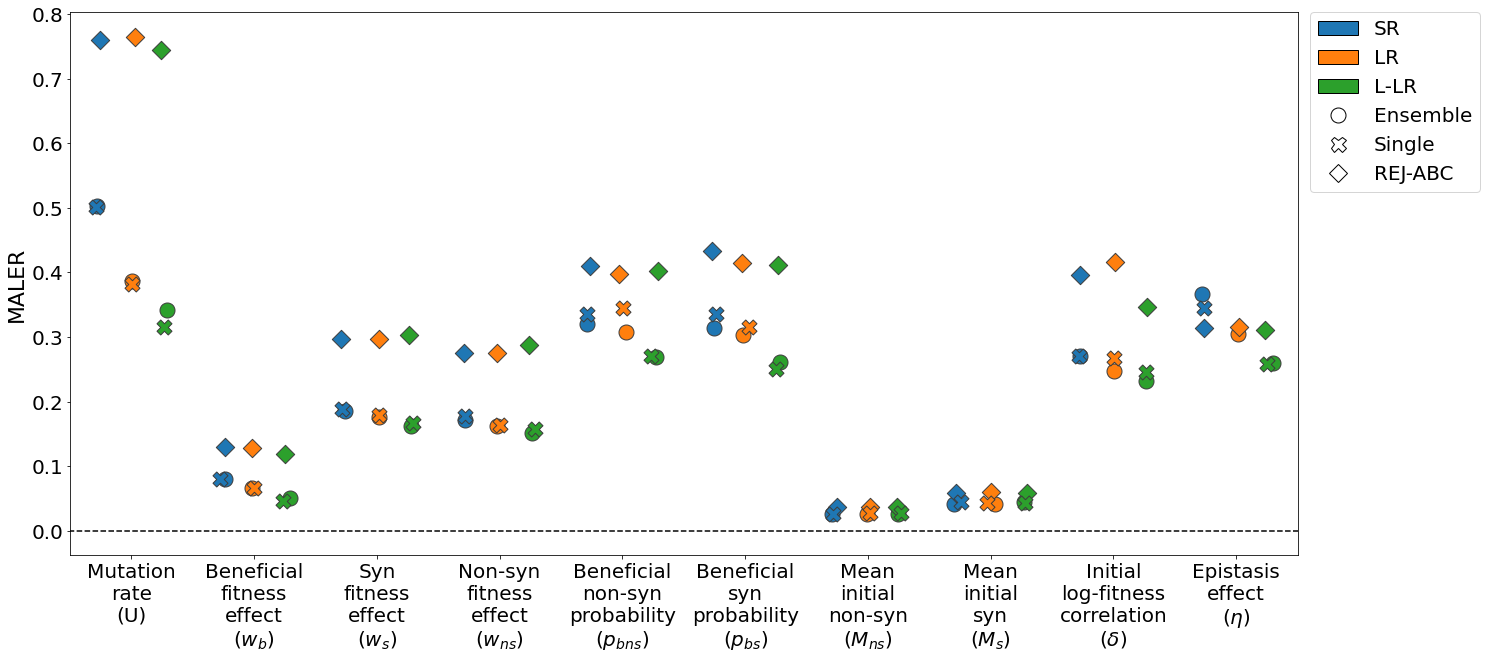

In [18]:
def mabs(col):
    return np.mean(abs(col))

def S1_S2_legend(marker_size):
    handles = []
    handles.append(mpatches.Patch(facecolor='C0', label='SR', edgecolor='k'))
    handles.append(mpatches.Patch(facecolor='C1', label='LR', edgecolor='k'))
    handles.append(mpatches.Patch(facecolor='C2', label='L-LR', edgecolor='k'))
    handles.append(plt.Line2D([0], [0], marker='o',markeredgecolor='k', markerfacecolor='white',
                              label='Ensemble', linestyle='None', markersize=marker_size))
    handles.append(plt.Line2D([0], [0], marker='X', markeredgecolor='k', markerfacecolor='white', 
                              label='Single', linestyle='None', markersize=marker_size))
    handles.append(plt.Line2D([0], [0], marker='D', markeredgecolor='k', markerfacecolor='white',
                              label='REJ-ABC', linestyle='None', markersize=marker_size-2))    
    plt.legend(handles=handles, bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0)

def plot_RMSEs(grids, palette=None):
    plt.figure(figsize=(22,10))
    col = 'err_ratio'
    data = []
    marker_size = 15
    for grid_name, grid in grids.items():
        datum = grid.groupby(['Inferred Parameter','model'])[col].apply(mabs).reset_index()
        if 'big' in grid_name:
            datum = datum[datum.model!='ensemble']
        datum['model_name'] = grid_name
        datum.loc[datum.model=='ensemble','model_name'] = grid_name + ' Ensemble'
        data.append(datum)
    data = pd.concat(data)
    plt.plot([-0.9,10], [0,0], '--k')
    ens = data[(data.model=='ensemble')]
    g = sns.stripplot(data=ens, x='Inferred Parameter', y=col, label='_nolegend', order=rename_dict.values(),
              hue="model_name", dodge=True, size=marker_size, linewidth=1, palette=palette)
    rej = data[(data.model=='rej')]
    g = sns.stripplot(data=rej, x='Inferred Parameter', y=col, label='_nolegend', order=rename_dict.values(),
              hue="model_name", dodge=True, size=marker_size-2, linewidth=1, palette=palette, marker='D')
    big = data[(data.model=='big_model.dill')]
    sns.stripplot(data=big, x='Inferred Parameter', y=col, marker='X', label='_nolegend',order=rename_dict.values(),
              hue="model_name", dodge=True, size=marker_size, linewidth=1, palette=palette)
    plt.ylabel('MALER')
    plt.xlabel('')
    S1_S2_legend(marker_size)
    fix_x_ticks()
    
plot_RMSEs(grids_low_errs)

In [ ]:
grids_low_errs

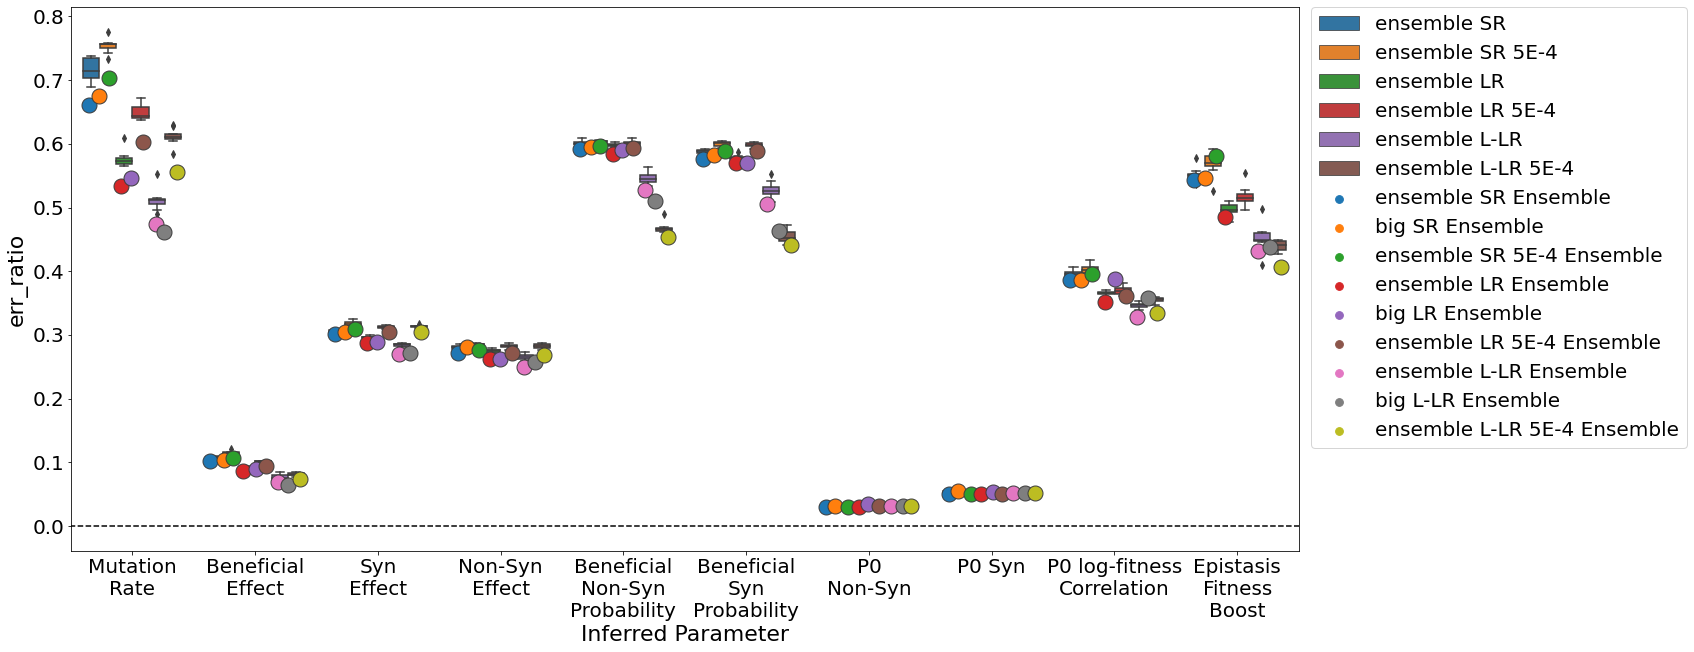

In [15]:
plt.figure(figsize=(22,10))
col = 'err_ratio'
palette = None
data = []
marker_size = 15
for grid_name, grid in grids.items():
    datum = grid.groupby(['Inferred Parameter','model'])[col].apply(rms).reset_index()
    if 'big' in grid_name:
        datum = datum[datum.model!='ensemble']
    datum['model_name'] = grid_name
    datum.loc[datum.model=='ensemble','model_name'] = grid_name + ' Ensemble'
    data.append(datum)
data = pd.concat(data)
ens = data[(data.model=='ensemble')]
smalls = data[(data.model!='ensemble') & (data.model!='big_model.dill')  & (data.model!='rej')]
sns.boxplot(data=smalls, x='Inferred Parameter', y=col,
            hue='model_name', order=rename_dict.values(), palette=palette)
plt.plot([-0.9,10], [0,0], '--k')
g = sns.stripplot(data=ens, x='Inferred Parameter', y=col, label='_nolegend', order=rename_dict.values(),
          hue="model_name", dodge=True, size=marker_size, linewidth=1, palette=palette)
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0)

# Fig S1

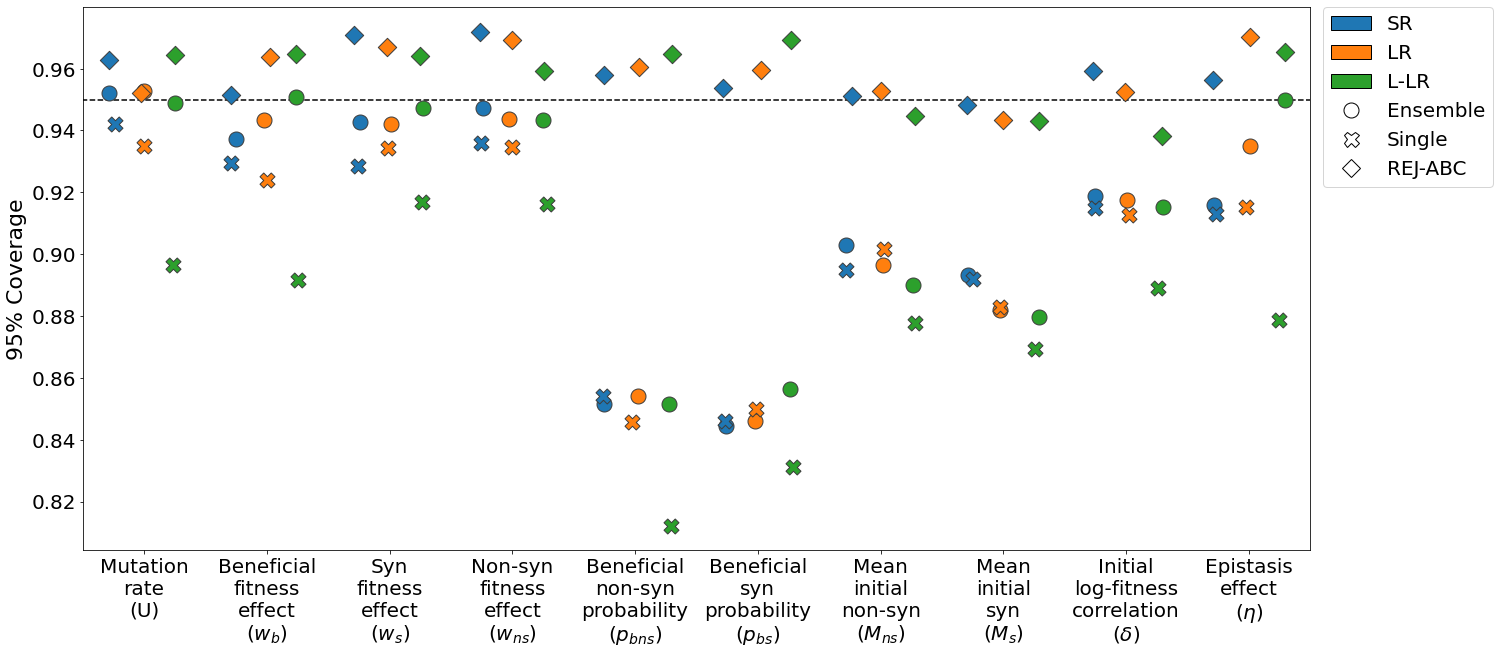

In [21]:
def plot_coverage(grids, palette=None):
    plt.figure(figsize=(22,10))
    data = []
    marker_size = 15
    for grid_name, grid in grids.items():
        datum = grid.groupby(['Inferred Parameter','model']).in_range.mean().reset_index()
        if 'big' in grid_name:
            datum = datum[datum.model!='ensemble']
        datum['model_name'] = grid_name
        datum.loc[datum.model=='ensemble','model_name'] = grid_name + ' Ensemble'
        data.append(datum)
    data = pd.concat(data)
    plt.plot([-0.9,10], [0.95,0.95], '--k')
    ens = data[(data.model=='ensemble')]
    g= sns.stripplot(data=ens, x='Inferred Parameter', y='in_range', label='_nolegend',order=rename_dict.values(),
              hue="model_name", dodge=True, size=marker_size, linewidth=1, palette=palette)
    rej = data[(data.model=='rej')]
    g = sns.stripplot(data=rej, x='Inferred Parameter', y='in_range', label='_nolegend', order=rename_dict.values(),
              hue="model_name", dodge=True, size=marker_size-2, linewidth=1, palette=palette, marker='D')
    big = data[(data.model=='big_model.dill')]
    g = sns.stripplot(data=big, x='Inferred Parameter', y='in_range', marker='X', label='_nolegend',order=rename_dict.values(),
              hue="model_name", dodge=True, size=marker_size, linewidth=1, palette=palette)

    plt.ylabel('95% Coverage')
    plt.xlabel('')
    S1_S2_legend(marker_size)
    fix_x_ticks()
plot_coverage(grids_low_errs, None)


In [15]:
shorts = {k: v for k,v in grids.items() if 'short' in k}
longs = {k: v for k,v in grids.items() if 'long' in k}
mans = {k: v for k,v in grids.items() if 'man' in k}
not_big = {k: v for k,v in grids.items() if 'big' not in k}

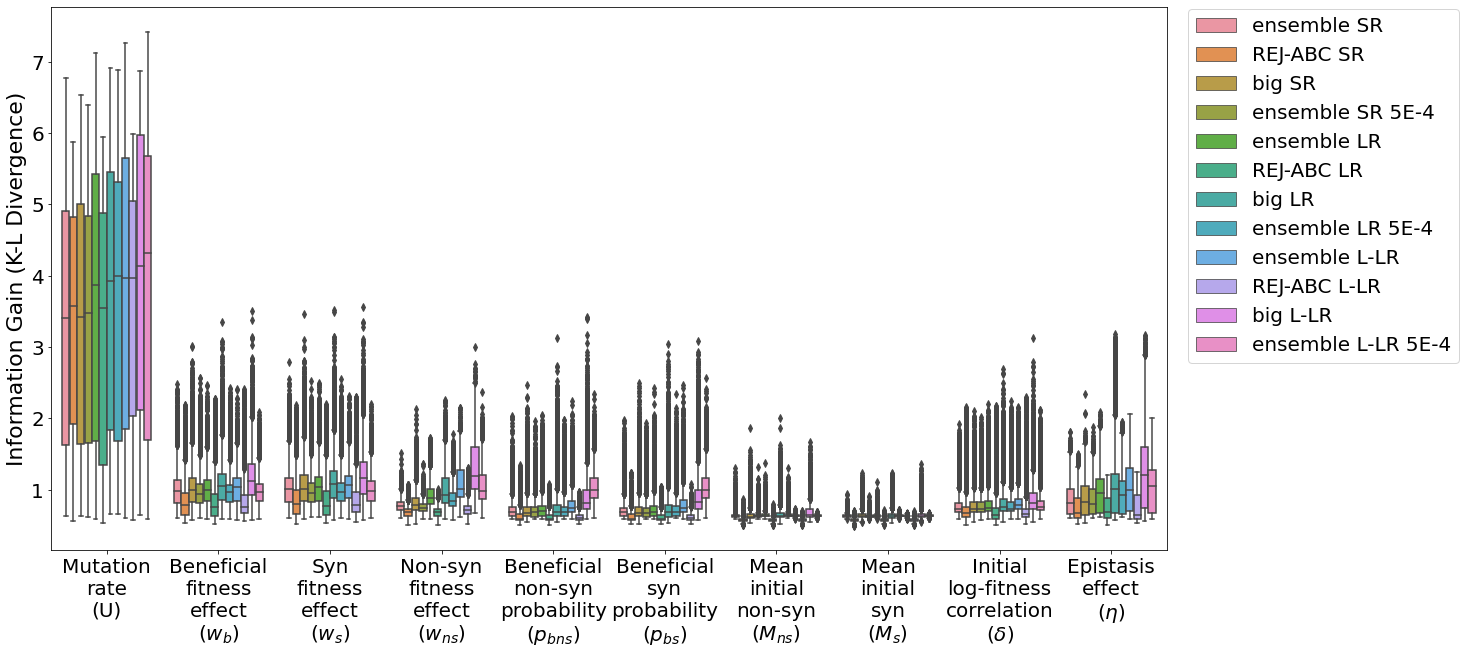

In [45]:
def compare_grids_DKL(grids):
    data = []
    for grid_name, grid in grids.items():
        datum = grid.copy()
        if 'REJ' not in grid_name:
            datum = datum[datum.model=='ensemble']
        datum['model_name'] = grid_name
        data.append(datum)
    data = pd.concat(data)
    data.param = data.param.map(lambda p: rename_dict[p])
    plt.figure(figsize=(20,10))
    sns.boxplot(data=data, x='param', y='DKL', hue='model_name')
    plt.ylabel('Information Gain (K-L Divergence)')
    plt.legend(bbox_to_anchor=(1.01,1.015))
    plt.xlabel('')
    fix_x_ticks()
compare_grids_DKL(grids)

# Fig S3

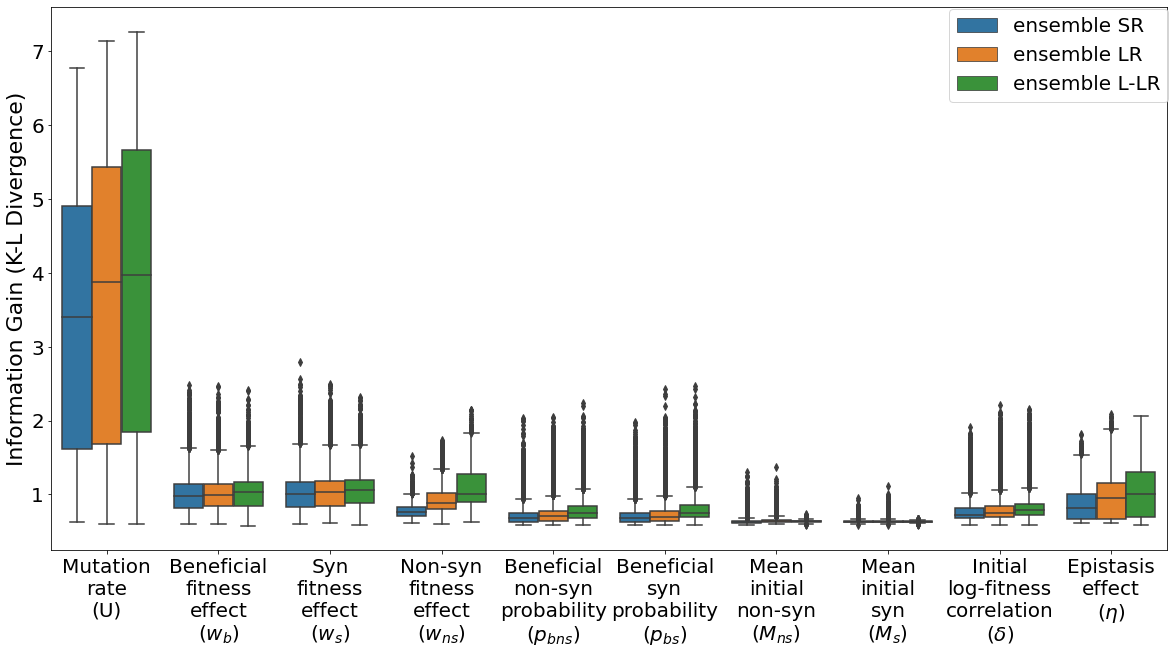

In [46]:
compare_grids_DKL({k: grids[k] for k in ['ensemble SR', 'ensemble LR', 'ensemble L-LR']})

In [18]:
def error_hists(data_dict, colors=None, bins=20):
    fig, axes = plt.subplots(3, 3, figsize=(18,15), constrained_layout=True)
    ax_dict = {'Mutation\nRate': (0,1), 'Syn\nEffect': (0,2), 'Non-Syn\nEffect': (0,0), 
               'Beneficial\nEffect': (2,0), 'P0 log-fitness\nCorrelation': (2,2), 
               'Epistasis\nFitness\nBoost': (2,1), 
               'Beneficial\nSyn\nProbability': (1,2), 'Beneficial\nNon-Syn\nProbability': (1,0)}
    #fig.suptitle('log10(Parameter MAP Error Ratio)')
    legend = True
    if not colors:
        colors = sns.color_palette(None)
    for param in list(data_dict.values())[0]['Inferred Parameter'].unique():
        if 'P0\n' in param or 'P0 S' in param:
            continue
        for i, (grid_name, grid) in enumerate(data_dict.items()):
            #TODO: add ensemble thing
            tmp = grid[(grid['Inferred Parameter']==param)]
            if 'REJ' not in grid_name and 'BIG' not in grid_name:
                tmp = tmp[(tmp['model']=='ensemble')]
            ax = axes[ax_dict[param]]
            col = 'err' if 'Mutation' in param else 'rel_err'
            histtype = 'bar'
            if 'REJ' in grid_name:
                histtype = 'step'
            tmp[col].sample(1000).hist(bins=bins, alpha=0.5, label=grid_name if legend else '_nolegend', ax=ax,
                                       color=colors[i], histtype=histtype, density=True)
            if 'BIG' in grid_name:
                rmse_big = np.mean(tmp[col]**2)
            else:
                rmse = np.mean(tmp[col]**2)
        xlabel = param.replace('\n', ' ')
        #if len(data_dict)==2:
        #    xlabel += '\n RMSE_big/RMSE: ' + str(round(rmse_big/rmse,2))
        ax.set_xlabel('log10(MAP Error Ratio)')
        ax.set_ylabel('Density')
        ax.set_title(xlabel)
        legend = False
    fig.delaxes(axes[(1,1)])
    #fig.delaxes(axes[(2,1)])
    fig.legend(loc=(0.45,0.45))


# Fig 4

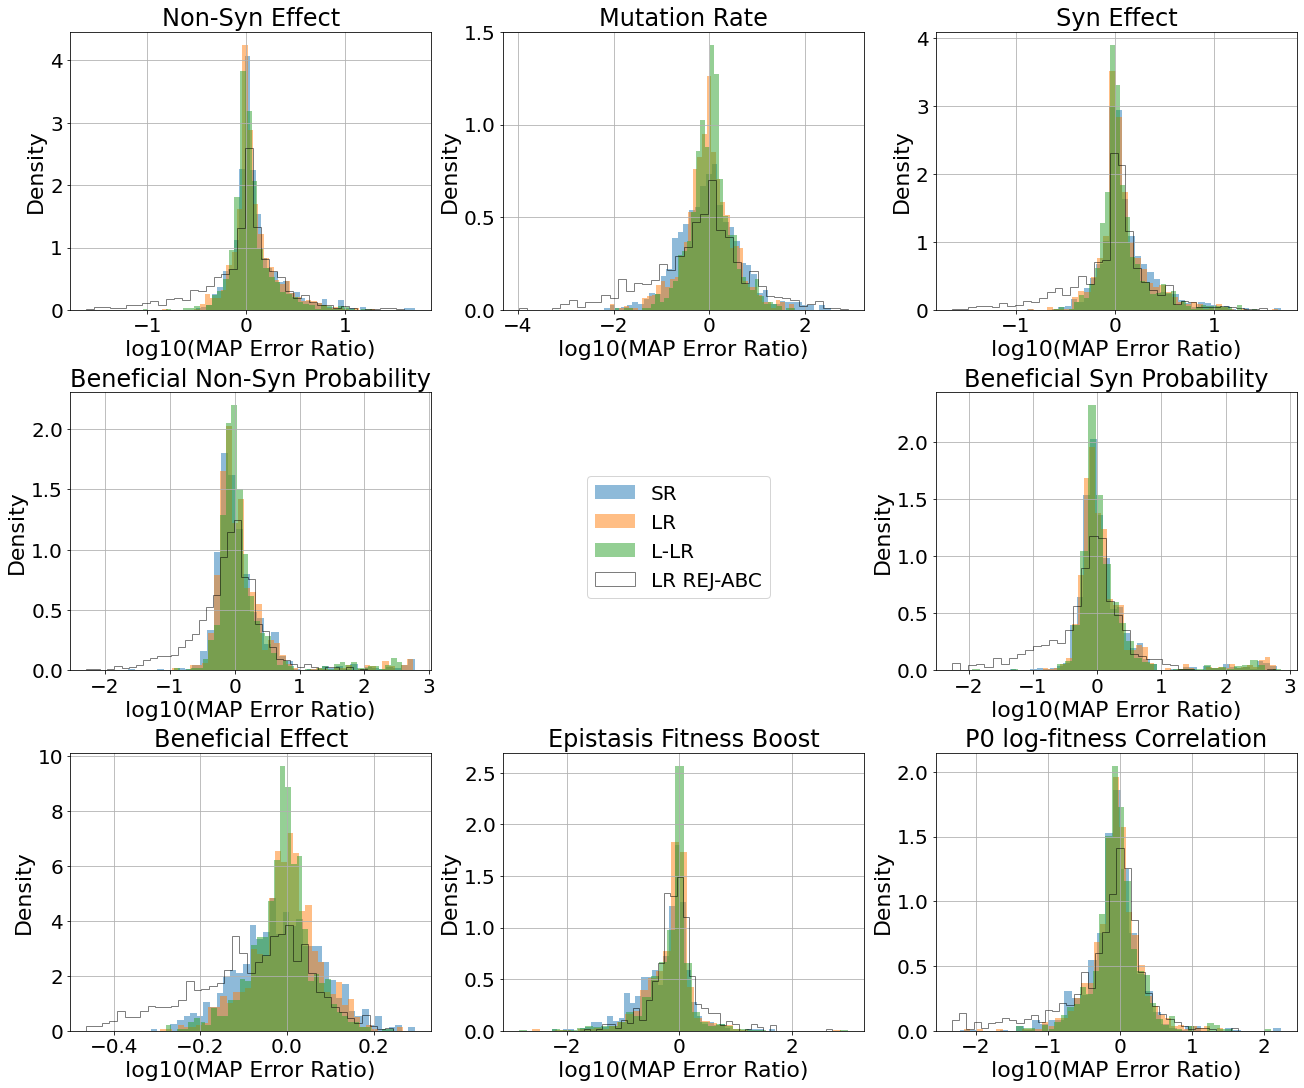

In [19]:
error_hists({k: grids[k] for k in ['SR', 'LR', 'L-LR', 'LR REJ-ABC']}, colors=sns.color_palette(None)[:3]+['k','red'], bins=40)

## Absolute mean MAP error ratios

In [29]:
for k in ['SR','LR','L-LR', 'LR REJ-ABC']:
    print(k)
    print(test[k][(test[k].param=='mu') & (test[k].model=='ensemble')].err.abs().mean())
    if 'REJ' in k:
        print(test[k][(test[k].param=='mu')].err.abs().mean())

SR
0.5225953724982745
LR
0.3916482384597409
L-LR
0.33177208806328073
LR REJ-ABC
nan
0.772127661514826
